In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 87% 289M/331M [00:00<00:00, 493MB/s]
100% 331M/331M [00:00<00:00, 506MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile('utkface-new.zip', 'r')
zip.extractall('utkface-new')
zip.close()

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [5]:
folder_path = '/content/utkface-new/UTKFace'

In [6]:
age = []
gender = []
img_path = []
for file in os.listdir(folder_path):
  # Assuming the filename format is age_gender_...
  file_parts = file.split('_')
  age.append(int(file_parts[0]))
  gender.append(int(file_parts[1]))
  img_path.append(file)

In [7]:
len(age), len(gender), len(img_path)

(23708, 23708, 23708)

In [8]:
df = pd.DataFrame({'age': age, 'gender': gender, 'img': img_path})

In [9]:
df.shape

(23708, 3)

In [10]:
df.head()

,age,gender,img
0,28,0,28_0_3_20170119194509114.jpg.chip.jpg
1,37,0,37_0_2_20170116192009515.jpg.chip.jpg
2,7,0,7_0_0_20170110215335739.jpg.chip.jpg
3,37,0,37_0_3_20170120221511381.jpg.chip.jpg
4,43,0,43_0_3_20170119162826244.jpg.chip.jpg


In [11]:
train_df = df.sample(frac=1, random_state=0).iloc[:20000]
test_df = df.sample(frac=1, random_state=0).iloc[20000:]

In [12]:
train_df.shape, test_df.shape

((20000, 3), (3708, 3))

In [13]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path, age, gender):
    full_image_path = tf.strings.join([folder_path, '/', image_path])
    img = tf.io.read_file(full_image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [200, 200])
    img = img / 255.0
    return img, {'age': age, 'gender': gender}

In [14]:
# Create the RandomRotation layer once (outside the function)
rotation_layer = tf.keras.layers.RandomRotation(factor=0.0417, fill_mode='nearest')
# 0.0417 ≈ 15 degrees in radians / π

# Function to augment image
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = rotation_layer(image)

    return image, label  # label is already a dict with keys 'age' and 'gender'



In [15]:
# Create tf.data.Dataset from training DataFrame
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['img'].values, train_df['age'].values, train_df['gender'].values)
)
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_augmented = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_augmented = train_dataset_augmented.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['img'].values, test_df['age'].values, test_df['gender'].values)
)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [18]:
vggnet = VGG16(include_top=False, weights='imagenet', input_shape=(200, 200, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
vggnet.trainable=False

output = vggnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(flatten)

dense3 = Dense(128, activation='relu')(dense1)
dense4 = Dense(64, activation='relu')(dense2)

output1 = Dense(1, activation='linear', name='age')(dense3)
output2 = Dense(1, activation='sigmoid', name='gender')(dense4)

model = Model(inputs=vggnet.input, outputs=[output1, output2])

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 12, 12,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 12, 12,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 12, 12,    │  2,359,808 │ block5_conv1[0][

 Total params: 33,688,770 (128.51 MB)

 Trainable params: 18,974,082 (72.38 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

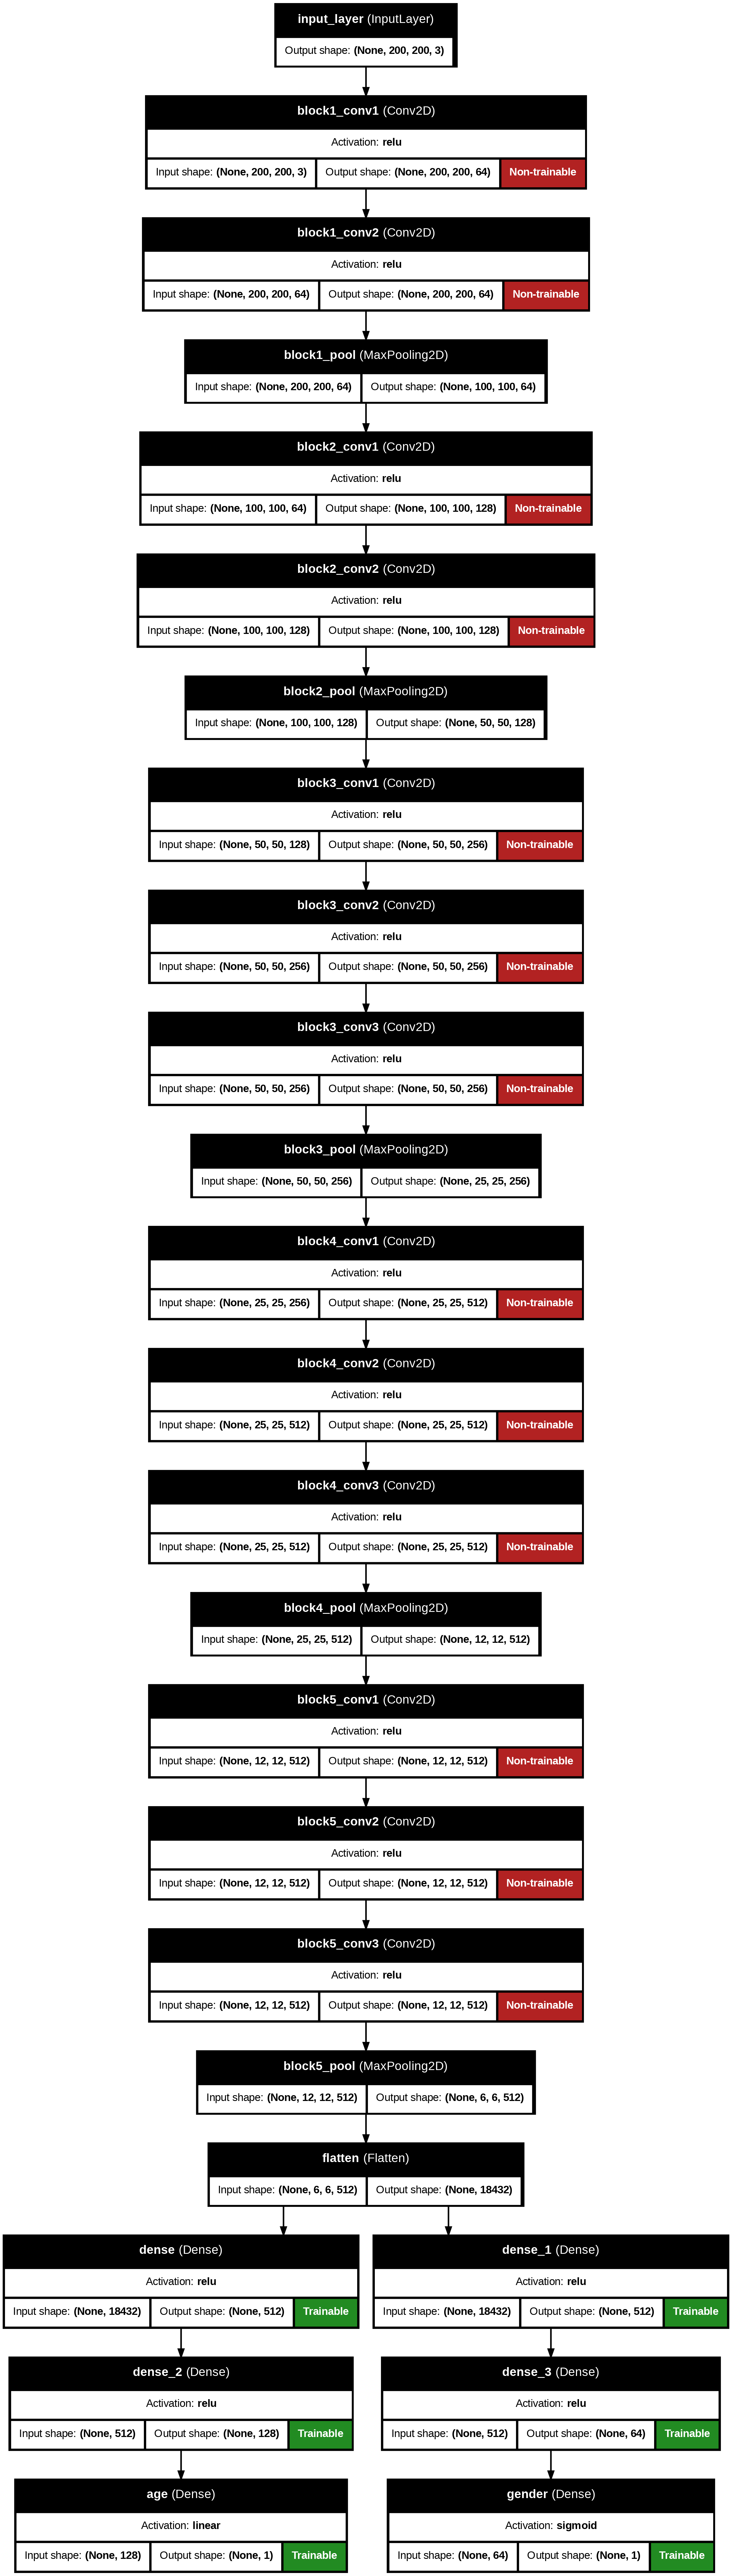

In [ ]:
from keras.utils import plot_model
plot_model(model , show_shapes=True, show_layer_names=True, show_layer_activations=True, show_trainable=True) 

In [22]:
model.compile(optimizer='adam', loss={'age': 'mse', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'}, loss_weights={'age':20 , 'gender':80})

In [23]:
model.fit(train_dataset_augmented, batch_size=32, validation_data=test_dataset, epochs=10)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 225s 332ms/step - age_loss: 224.3410 - age_mae: 11.1191 - gender_accuracy: 0.7729 - gender_loss: 0.5384 - loss: 4529.8931 - val_age_loss: 109.3968 - val_age_mae: 7.4939 - val_gender_accuracy: 0.8695 - val_gender_loss: 0.3086 - val_loss: 2213.2102
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 228s 296ms/step - age_loss: 110.7623 - age_mae: 7.7052 - gender_accuracy: 0.8549 - gender_loss: 0.3282 - loss: 2241.5022 - val_age_loss: 99.9480 - val_age_mae: 7.0141 - val_gender_accuracy: 0.8732 - val_gender_loss: 0.2858 - val_loss: 2022.0286
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 294ms/step - age_loss: 99.8874 - age_mae: 7.2628 - gender_accuracy: 0.8653 - gender_loss: 0.3020 - loss: 2021.9082 - val_age_loss: 101.2299 - val_age_mae: 7.2055 - val_gender_accuracy: 0.8153 - val_gender_loss: 0.3929 - val_loss: 2057.0696
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 190s 299ms/step - age_loss: 94.7799 - age_mae: 7.0928 - gender_accuracy: 0.8809 - gender_loss: 0.2789 -

In [25]:
for images, labels in test_dataset.take(1):
    preds = model.predict(images)
    predicted_ages = preds[0].flatten()
    predicted_genders = (preds[1].flatten() > 0.5).astype(int)  # Convert sigmoid to 0 or 1

    true_ages = labels['age'].numpy()
    true_genders = labels['gender'].numpy()

    for i in range(5):  # Show 5 examples
        print(f"Predicted Age: {predicted_ages[i]:.1f}, True Age: {true_ages[i]}")
        print(f"Predicted Gender: {'Male' if predicted_genders[i]==1 else 'Female'}, True Gender: {'Male' if true_genders[i]==1 else 'Female'}")
        print("---")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Age: 58.3, True Age: 65
Predicted Gender: Male, True Gender: Male
---
Predicted Age: 27.4, True Age: 26
Predicted Gender: Female, True Gender: Female
---
Predicted Age: 79.3, True Age: 84
Predicted Gender: Male, True Gender: Male
---
Predicted Age: 49.1, True Age: 60
Predicted Gender: Female, True Gender: Female
---
Predicted Age: 69.6, True Age: 57
Predicted Gender: Female, True Gender: Female
---


In [ ]:
from tensorflow.keras.preprocessing import image

def preprocess_custom_image(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Path to your custom image
custom_img = preprocess_custom_image('/content/IMG_2689.JPG')

# Predict
pred_age, pred_gender = model.predict(custom_img)

# Convert gender to label
gender_label = "Male" if pred_gender[0][0] > 0.5 else "Female"

# Print results
print(f"Predicted Age: {pred_age[0][0]:.1f}")
print(f"Predicted Gender: {gender_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Age: 20.6
Predicted Gender: Male


Confusion Matrix:
 [[1668  306]
 [ 122 1612]]

Classification Report:
               precision    recall  f1-score   support

      Female       0.93      0.84      0.89      1974
        Male       0.84      0.93      0.88      1734

    accuracy                           0.88      3708
   macro avg       0.89      0.89      0.88      3708
weighted avg       0.89      0.88      0.88      3708



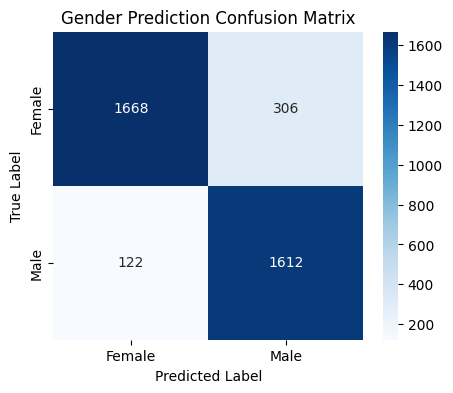

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Gather true and predicted genders
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Unpack true labels
    true_genders = labels['gender'].numpy()
    # Predict
    _, pred_genders = model.predict(images, verbose=0)
    pred_bin = (pred_genders.flatten() > 0.5).astype(int)

    y_true.extend(true_genders)
    y_pred.extend(pred_bin)

# Step 2: Compute confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Female", "Male"])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Step 3: Visualize
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Gender Prediction Confusion Matrix")
plt.show()